[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Jaruga_et_al_2015/fig19.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/Jaruga_et_al_2015/fig19.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Jaruga_et_al_2015/fig19.ipynb)

## Michał Kowalczyk AGH engineering project

## 2D Boussinesq (buoyancy-driven) flow example

### equations solved:
conservation of momentum (inviscid and incompressible form of Navier-Stokes equation)
$$
\partial_t v+\mathrm{\nabla}\cdot\left(\vec{v}\otimes \vec{v}\right)=-\mathrm{\nabla\pi}-\vec{g}\frac{\theta^\prime}{\theta_0}
$$
conservation of energy
$$
\partial_t \theta+ \mathrm{\nabla}\cdot\left(\vec{v}\theta\right)=0
$$
continuity equation(conservation of mass)
$$
\mathrm{\nabla}\cdot\ \vec{v}=0
$$

Based on buoyant-bubble test case from Fig. 3 in
[Smolarkiewicz & Pudykiewicz 1992](https://doi.org/10.1175/1520-0469(1992)049%3C2082:ACOSLA%3E2.0.CO;2),
as used in libmpdata++ paper ([Jaruga et al. 2015](https://doi.org/10.5194/gmd-8-1005-2015)), Fig. 19

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
import os

import warnings
from collections import namedtuple

from numba import njit as jit
from numba.core.errors import NumbaExperimentalFeatureWarning

import numpy as np
from matplotlib import colors, pyplot
import ipywidgets
from IPython.display import display

from open_atmos_jupyter_utils import show_plot
from open_atmos_jupyter_utils.show_anim import show_anim

from PyMPDATA import Options, ScalarField, VectorField, Solver, Stepper
from PyMPDATA.boundary_conditions import Periodic
from PyMPDATA.impl.enumerations import IMPL_META_AND_DATA, META_AND_DATA_DATA, IMPL_BC
from PyMPDATA.impl.clock import clock

## Parameters

In [3]:
OPTIONS = Options(n_iters=2, infinite_gauge=True, nonoscillatory=True)
CI = 'CI' in os.environ
CI=True

SETUP = {
    "outfreq": 1,
    "N": 200 if not CI else 100,
    "M": 200 if not CI else 100,
    "Tht_ref": 300.,
    "Tht_dlt": .5,
    "g": 9.81,
    "r0": 250.,
    "x0": 1000,
    "y0": 260,
    "dt": 0.75 if not CI else 1.5,
    "prs_tol": 1e-7,
    "k_iters": 4,
}

SETUP["nt"] = int(600//SETUP["dt"])
SETUP["err_tol"] = SETUP["prs_tol"] / SETUP["dt"]
SETUP["grid"] = SETUP["N"], SETUP["M"]
SETUP["dxy"] = (2000/SETUP["N"], 2000/SETUP["M"])
SETUP["halo"] = OPTIONS.n_halo
SETUP["grid_with_halo"] = SETUP["N"] + SETUP["halo"]*2, SETUP["M"] + SETUP["halo"]*2

SETUP = namedtuple("Setup", SETUP.keys())(**SETUP)

assert SETUP.dt * SETUP.nt == 600

## initial condition

In [4]:
xi, yi = np.indices(SETUP.grid)

mesh = np.full(SETUP.grid, fill_value=SETUP.Tht_ref, dtype=float)
mesh += np.where(
    np.sqrt(
        ((xi+1/2) * SETUP.dxy[0] - SETUP.x0)**2 +
        ((yi+1/2) * SETUP.dxy[1] - SETUP.y0)**2
    ) < SETUP.r0,
    SETUP.Tht_dlt,
    0
)

## PyMPDATA setup

In [5]:
_U, _W, _T = 0, 1, 2

bcond = (Periodic(), Periodic())
field_ctor_kwargs = {'halo': SETUP.halo, 'boundary_conditions': bcond}


stepper = Stepper(options=OPTIONS, grid=SETUP.grid,n_threads = 1)


def new_sf(g):
    field = ScalarField(data=np.zeros(g), **field_ctor_kwargs)
    field.assemble(stepper.traversals)
    return field



def initialize():
    advector = VectorField(data=(
            np.zeros((SETUP.N+1, SETUP.M)),
            np.zeros((SETUP.N, SETUP.M+1))
        ), **field_ctor_kwargs)
    advector.assemble(stepper.traversals)
    solver_ctor_kwargs = {'stepper': stepper, 'advector': advector}
    solvers = {
        _U: Solver(advectee=new_sf(SETUP.grid), **solver_ctor_kwargs),
        _W: Solver(advectee=new_sf(SETUP.grid), **solver_ctor_kwargs),
        _T: Solver(advectee=ScalarField(data=mesh, **field_ctor_kwargs), **solver_ctor_kwargs),
    }

    

    ADVECTEE_DATA = tuple(
        solvers[idx].advectee.data for idx in range(3)
    )
    
    ADVECTOR_DATA = tuple(
        datum for datum in advector.data
    )
    
    ARRAYS = {
        "rhs_w": np.zeros(SETUP.grid),
        "stash": np.zeros((len(SETUP.grid), *SETUP.grid_with_halo)),
        "vip_rhs": np.zeros((len(SETUP.grid), *SETUP.grid_with_halo)),
        "Phi": np.zeros(SETUP.grid_with_halo),
        "tmp_uvw": np.zeros((len(SETUP.grid), *SETUP.grid_with_halo)),
        "lap_tmp": np.zeros((len(SETUP.grid), *SETUP.grid_with_halo)),
        "lap_err": np.zeros(SETUP.grid),
        "err": np.zeros(SETUP.grid_with_halo),
        "p_err": np.zeros((SETUP.k_iters, *SETUP.grid_with_halo)),
        "lap_p_err": np.zeros((SETUP.k_iters, *SETUP.grid)),
    }
    ARRAYS = namedtuple("Arrays", ARRAYS.keys())(**ARRAYS)
    return ARRAYS, ADVECTOR_DATA, ADVECTEE_DATA, solvers

IDX = {
    "interior": (slice(SETUP.halo, -SETUP.halo), slice(SETUP.halo, -SETUP.halo)),
    "grad_left": (
        (slice(SETUP.halo + 1, None if SETUP.halo==1 else (-SETUP.halo+1)), slice(SETUP.halo,-SETUP.halo)),
        (slice(SETUP.halo,-SETUP.halo), slice(SETUP.halo+1,None if SETUP.halo==1 else (-SETUP.halo+1)))
    ),
    "grad_right": (
        (slice(None if SETUP.halo==1 else (SETUP.halo-1),-SETUP.halo-1), slice(SETUP.halo,-SETUP.halo)),
        (slice(SETUP.halo,-SETUP.halo), slice(None if SETUP.halo==1 else (SETUP.halo-1), -SETUP.halo-1))
    ),
    "intrp_left": ( 
        (slice(None, -1), slice(None, None)),
        (slice(None, None), slice(None, -1)),
    ),
    "intrp_right": ( 
        (slice(1, None), slice(None, None)),
        (slice(None, None), slice(1, None)),
    )
}
IDX = namedtuple("Idx", IDX.keys())(**IDX)

ARRAYS, ADVECTOR_DATA, ADVECTEE_DATA, solvers = initialize()
# note: all code below will be replaced by an implementation of PostStep hook referring to above methods
MPDATA_STEPPERS = tuple(
    solvers[k]._Solver__stepper._Stepper__call for k in (_U, _W, _T)#pylint: disable=protected-access
)

from PyMPDATA import solver
MPDATA_ANTE_STEP = solver.AnteStepNull()
MPDATA_POST_STEP = solver.PostStepNull() 
MPDATA_POST_ITER = solver.PostIterNull()

from PyMPDATA.impl.meta import _Impl

MPDATA_TRAVERSALS_DATA = tuple(
    solvers[k]._Solver__stepper.traversals.data for k in (_U, _W, _T)#pylint: disable=protected-access
)

MPDATA_FIELDS = [
    [
        _Impl(field=(vv:=v[0] if isinstance(v, tuple) else v).impl[IMPL_META_AND_DATA], bc=vv.impl[IMPL_BC])#pylint: disable=protected-access
        for v in solvers[k]._Solver__fields.values()#pylint: disable=protected-access
    ] for k in (_U, _W, _T)
]
for k in (_U, _W, _T):
    MPDATA_FIELDS[k][0] = (MPDATA_FIELDS[k][0],) 
    MPDATA_FIELDS[k] = tuple(MPDATA_FIELDS[k])
MPDATA_FIELDS = tuple(MPDATA_FIELDS)

## JIT-compilable functions

In [6]:
fill_halos_scalar = stepper.traversals._code["fill_halos_scalar"]#pylint: disable=protected-access

@jit(**OPTIONS.jit_flags)
def grad(psi, axis):
    return (psi[IDX.grad_left[axis]] - psi[IDX.grad_right[axis]]) / 2 / SETUP.dxy[axis]
    
@jit(**OPTIONS.jit_flags)
def calc_grad_Phi(arg, phi):
    for k in (0,1):
        arg[k][IDX.interior] = grad(phi, axis=k)

@jit(**OPTIONS.jit_flags)
def data(impl):
    return impl[IMPL_META_AND_DATA][META_AND_DATA_DATA]

@jit(**OPTIONS.jit_flags)
def pressure_solver_loop_body(ARRAYS,converged):
    """[page 151 in Smolarkiewicz Margolin 2000](https://osti.gov/biblio/785403)"""
    tmp_den = [1.] * SETUP.k_iters
    alpha = [1.] * SETUP.k_iters
    for v in range(0, SETUP.k_iters):
        tmp_den[v] = np.sum(ARRAYS.lap_p_err[v]**2)
        if tmp_den[v] != 0:
            beta = - np.dot(
                ARRAYS.err[IDX.interior].ravel(),
                ARRAYS.lap_p_err[v].ravel()
            ) / tmp_den[v]
        else:
            beta = .25
        ARRAYS.Phi[IDX.interior][:] += beta * ARRAYS.p_err[v][IDX.interior]
        ARRAYS.err[IDX.interior][:] += beta * ARRAYS.lap_p_err[v]

        error = max(
            abs(np.amax(ARRAYS.err[IDX.interior])),
            abs(np.amin(ARRAYS.err[IDX.interior]))
        )

        if error <= SETUP.err_tol: 
            converged = True

        ARRAYS.lap_err[:] = lap(ARRAYS.err,False,ARRAYS)

        for l in range(v):
            if tmp_den[l] != 0:
                alpha[l] = - np.dot(ARRAYS.lap_err.ravel(), ARRAYS.lap_p_err[l].ravel()) / tmp_den[l]
        if v < SETUP.k_iters - 1:
            ARRAYS.p_err[v + 1][IDX.interior][:] = ARRAYS.err[IDX.interior]
            ARRAYS.lap_p_err[v + 1][:] = ARRAYS.lap_err
            for l in range(v):
                ARRAYS.p_err[v + 1][IDX.interior][:] += alpha[l] * ARRAYS.p_err[l][IDX.interior]
                ARRAYS.lap_p_err[v + 1][:] += alpha[l] * ARRAYS.lap_p_err[l]
        else:
            ARRAYS.p_err[0][IDX.interior][:] = ARRAYS.err[IDX.interior][:] + alpha[0] * ARRAYS.p_err[0][IDX.interior]
            ARRAYS.lap_p_err[0][:] = ARRAYS.lap_err[:] + alpha[0] * ARRAYS.lap_p_err[0]
            for l in range(1, v+1):
                ARRAYS.p_err[0][IDX.interior][:] += alpha[l] * ARRAYS.p_err[l][IDX.interior]
                ARRAYS.lap_p_err[0][:] += alpha[l] * ARRAYS.lap_p_err[l]
    return converged

@jit(**OPTIONS.jit_flags)
def calc_gc_interpolate_in_space(ARRAYS,ADVECTOR_DATA):
    for axis in (_U, _W):
        ADVECTOR_DATA[axis][:] = SETUP.dt / SETUP.dxy[axis] * (
            (
                ARRAYS.stash[axis][IDX.intrp_right[axis]] - 
                ARRAYS.stash[axis][IDX.intrp_left[axis]]
            ) / 2 + ARRAYS.stash[axis][IDX.intrp_left[axis]]
        )

@jit(**OPTIONS.jit_flags)
def ini_pressure(ARRAYS,ADVECTEE_DATA):
    for k in (_U, _W):
        ARRAYS.Phi[IDX.interior][:] -= 0.5 * np.power(ADVECTEE_DATA[k][IDX.interior][:], 2)
    ARRAYS.Phi[IDX.interior][:] -= np.sum(ARRAYS.Phi[IDX.interior]) / (SETUP.N * SETUP.M)

@jit(**OPTIONS.jit_flags)
def lap(Phi, err_init,ARRAYS): 
    xchng_pres_old(Phi)
    calc_grad_Phi(ARRAYS.lap_tmp, Phi)

    if err_init:
        for k in (_U, _W):
            ARRAYS.lap_tmp[k][:] -= ARRAYS.tmp_uvw[k]

    for k in (_U, _W):
        xchng_pres_old(ARRAYS.lap_tmp[k])
        
    return (
        grad(ARRAYS.lap_tmp[0], axis=0) +
        grad(ARRAYS.lap_tmp[1], axis=1)
    )

@jit(**OPTIONS.jit_flags)
def pressure_solver_loop_init(ARRAYS):
    ARRAYS.p_err[0][IDX.interior][:] = ARRAYS.err[IDX.interior]
    ARRAYS.lap_p_err[0][:] = lap(ARRAYS.p_err[0], False,ARRAYS)

@jit(**OPTIONS.jit_flags)
def pressure_solver_update(ARRAYS,ADVECTEE_DATA):
    for k in (_U, _W):
        ARRAYS.tmp_uvw[k][:] = ADVECTEE_DATA[k]
    ARRAYS.err[IDX.interior][:] = lap(ARRAYS.Phi, True,ARRAYS)
    pressure_solver_loop_init(ARRAYS)

    iters, converged = 0, False
    while not converged:        
        converged = pressure_solver_loop_body(ARRAYS,converged)
        iters += 1
        if iters > 10000:
            raise ArithmeticError("stuck in pressure solver")
             
    xchng_pres_old(ARRAYS.Phi)
    calc_grad_Phi(ARRAYS.tmp_uvw, ARRAYS.Phi)

@jit(**OPTIONS.jit_flags)
def calc_gc_extrapolate_in_time(ARRAYS,ADVECTEE_DATA):
    """[equation 32 in Smolarkiewicz Margolin 1998](https://doi.org/10.1006/jcph.1998.5901)"""
    for k in (_U, _W):
        ARRAYS.stash[k][IDX.interior] = -.5 * ARRAYS.stash[k][IDX.interior] + 1.5 * ADVECTEE_DATA[k][IDX.interior]
        ARRAYS.stash[k][IDX.interior] = -.5 * ARRAYS.stash[k][IDX.interior] + 1.5 * ADVECTEE_DATA[k][IDX.interior]
        xchng_pres_old(ARRAYS.stash[k])

@jit(**OPTIONS.jit_flags)
def fill_stash(ARRAYS,ADVECTEE_DATA):
    for k in (_U, _W):
        ARRAYS.stash[k][IDX.interior] = ADVECTEE_DATA[k][IDX.interior]
        xchng_pres_old(ARRAYS.stash[k])
        
@jit(**OPTIONS.jit_flags)
def xchng_pres_old(data):
    data[0:SETUP.halo, :] = data[-2*SETUP.halo:-SETUP.halo,:]
    data[-SETUP.halo:, :] = data[SETUP.halo:2*SETUP.halo, :]
    data[:,0:SETUP.halo] = data[:,-2*SETUP.halo : -SETUP.halo]
    data[:,-SETUP.halo:] = data[:,SETUP.halo : 2*SETUP.halo]

@jit(**OPTIONS.jit_flags)
def vip_rhs_apply(ARRAYS,ADVECTEE_DATA):
    for k in (_U, _W):
        ADVECTEE_DATA[k][:] += 0.5 * SETUP.dt * ARRAYS.vip_rhs[k]
        ARRAYS.vip_rhs[k][:] = 0

@jit(**OPTIONS.jit_flags)
def apply_half_rhs(ARRAYS,ADVECTEE_DATA):              
    ADVECTEE_DATA[_W][IDX.interior] += ARRAYS.rhs_w * SETUP.dt/2

@jit(**OPTIONS.jit_flags)
def finilize_rhs(ARRAYS,ADVECTEE_DATA):
    for k in (_U, _W):
        ARRAYS.vip_rhs[k][:] = -ADVECTEE_DATA[k]

@jit(**OPTIONS.jit_flags)
def update_rhs(ARRAYS,ADVECTEE_DATA):
    ARRAYS.rhs_w[:] = SETUP.g * (ADVECTEE_DATA[_T][IDX.interior] - SETUP.Tht_ref) / SETUP.Tht_ref

@jit(**OPTIONS.jit_flags)
def pressure_solver_apply(ARRAYS,ADVECTEE_DATA):
    for k in (_U, _W):
        ADVECTEE_DATA[k][:] -= ARRAYS.tmp_uvw[k]
        ARRAYS.vip_rhs[k][:] += ADVECTEE_DATA[k]
        ARRAYS.vip_rhs[k][:] /= 0.5 * SETUP.dt

@jit(**OPTIONS.jit_flags)
def mpdata_advance(steppers, ante_step, post_step, post_iter, fields, traversals_data):
    n_steps = 1
    mu_coeff = (0,0,0)
    wall_time = 0
    for k in (_U, _W, _T):
        wall_time += steppers[k](
            n_steps, 
            mu_coeff, 
            ante_step,
            post_step,
            post_iter,
            *fields[k],
            traversals_data[k]
        )
    return wall_time

@jit(**OPTIONS.jit_flags)
def advance(amount,ARRAYS,ADVECTOR_DATA, ADVECTEE_DATA,MPDATA_STEPPERS, MPDATA_ANTE_STEP, MPDATA_POST_STEP, 
                   MPDATA_POST_ITER, MPDATA_FIELDS, MPDATA_TRAVERSALS_DATA,output):
    times = np.zeros(SETUP.nt)
    t0 = clock()
    for step in range(amount + 1):
        if step != 0:
            times[step-1] = clock()-t0
            calc_gc_extrapolate_in_time(ARRAYS, ADVECTEE_DATA) 
            calc_gc_interpolate_in_space(ARRAYS, ADVECTOR_DATA) 
            fill_stash(ARRAYS, ADVECTEE_DATA)
            apply_half_rhs(ARRAYS, ADVECTEE_DATA)
            vip_rhs_apply(ARRAYS, ADVECTEE_DATA)
            mpdata_advance(MPDATA_STEPPERS, MPDATA_ANTE_STEP, MPDATA_POST_STEP, MPDATA_POST_ITER, MPDATA_FIELDS,
                           MPDATA_TRAVERSALS_DATA)
            update_rhs(ARRAYS, ADVECTEE_DATA)
            apply_half_rhs(ARRAYS, ADVECTEE_DATA)
            finilize_rhs(ARRAYS, ADVECTEE_DATA)
            pressure_solver_update(ARRAYS, ADVECTEE_DATA)
            pressure_solver_apply(ARRAYS, ADVECTEE_DATA)
        if step % SETUP.outfreq == 0:
            output[step//SETUP.outfreq] = ADVECTEE_DATA[_T][IDX.interior]

    return times

## Memory allocations, initial condition, and simulation loop

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore",category=NumbaExperimentalFeatureWarning)
    output = np.empty((SETUP.nt//SETUP.outfreq+1, *SETUP.grid))
    times = advance(SETUP.nt,ARRAYS,ADVECTOR_DATA, ADVECTEE_DATA, MPDATA_STEPPERS, MPDATA_ANTE_STEP, MPDATA_POST_STEP, 
                   MPDATA_POST_ITER, MPDATA_FIELDS, MPDATA_TRAVERSALS_DATA,output)

print(f"{np.min(times)=} {np.mean(times)=} {np.max(times)=}")
with open("output.npy", 'wb') as f:
    np.save(f, np.array(output))

np.min(times)=np.float64(37424.0) np.mean(times)=np.float64(24427831425.1425) np.max(times)=np.float64(56895706287.0)


## Visualisation

FloatProgress(value=0.0, max=40.1)


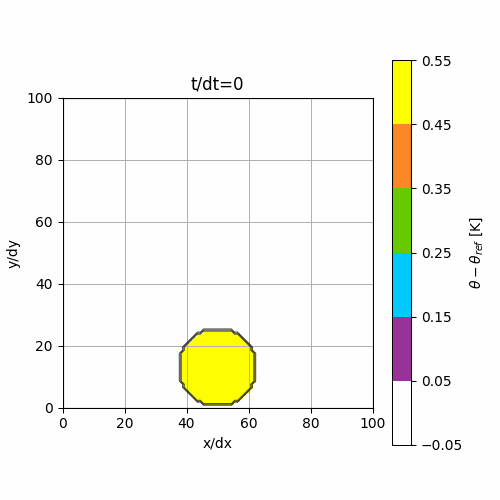

HTML(value="<a href='./boussinesq_2d_anim.gif' target='_blank'>./boussinesq_2d_anim.gif</a><br>")

In [8]:
freq = int(10)
progress = ipywidgets.FloatProgress(max=len(output)/freq)

def plot(step,plotflag=False):
    data = output[step]-SETUP.Tht_ref
    grid = data.shape
    x, y = np.indices(grid)
    colorticks = np.linspace(299.95-SETUP.Tht_ref, 300.55-SETUP.Tht_ref, 7, endpoint=True)
    cmap = colors.ListedColormap(["white", "#993399", "#00CCFF", "#66CC00","#FC8727","#FFFF00"])

    fig = pyplot.figure(figsize=(5,5))
    pyplot.title("t/dt="+str(step))
    pyplot.xlabel("x/dx")
    pyplot.ylabel("y/dy")
    pyplot.contour(x+1/2, y+1/2, data, levels=colorticks[1:], colors='k',linewidths=0.3)
    pyplot.imshow(data.T, origin="lower", extent=(0, grid[0], 0, grid[1]),
                  cmap=cmap, vmin=colorticks[0], vmax=colorticks[-1])
    pyplot.grid()
    label = "$θ-θ_{ref}$ [K]"
    if plotflag:
        cax = pyplot.axes([0.95, 0.184, 0.05,0.621])
        pyplot.colorbar(ticks=colorticks,label = label,cax = cax)
    else:
        pyplot.colorbar(ticks=colorticks,label = label)
    progress.value += 1
    return fig
    
display(progress)
show_anim(plot, frame_range=range(len(output))[::freq],gif_file='boussinesq_2d_anim.gif')

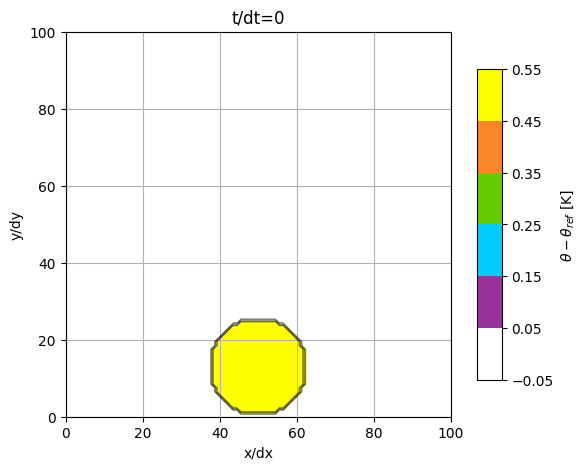

In [9]:
show_plot(fig=plot(0,True),inline_format='png')

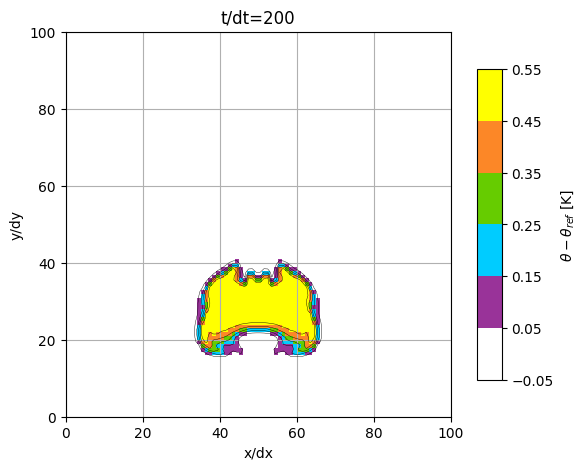

In [10]:
show_plot(fig=plot(int(len(output)/2),True),inline_format='png')

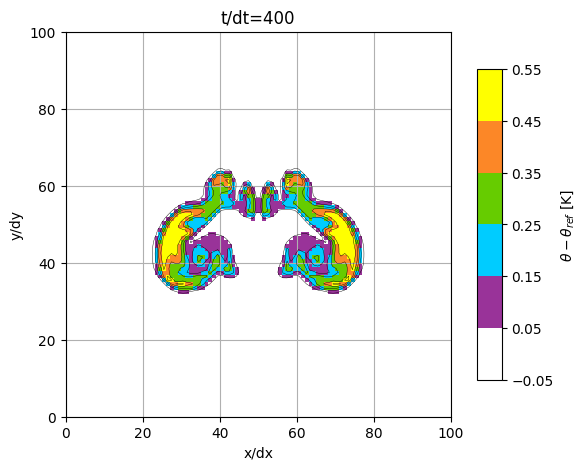

In [11]:
show_plot(fig=plot(len(output)-1,True),inline_format='png')